# Randomly create a group and calculate the distance to the Pareto front

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import itertools
import random
import time
from statistics import variance
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from scipy.stats import norm
from util import pickle_load, robust_z
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import optuna
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import comb
import math
from scipy.stats import pearsonr

In [62]:
test_num = "0901"
lig = "ago"
date = 241219
num = 1
seed = 42

In [63]:
if test_num in ["0701", "0702", "0907", "1001", "1002"]:
    if lig == "ago":
        lig = "!"
    else:
        pass
trys = str(date) + "_" + str(num)

if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num

In [64]:
pareto = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/pareto_front.tsv", sep="\t", header=None)

lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

In [65]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

if len(set(all_toxs)) == 2:
    tox_scoring = "descrete"
else:
    tox_scoring = "continuous"

if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [66]:
pops = []
smiles_pops = []
count = 0
IND_INIT_SIZE = len(val)

now = time.ctime()
cnvtime = time.strptime(now)

progress_bar = tqdm(total=1000, desc="Processing")

while count < 1000:
    a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
    a = set(a)
    while len(a) != IND_INIT_SIZE:
        a.add(random.randint(0, len(cas_tox)-1))
    score_moo = multi_objective_optimization(a)
    smiles_pops.append(list(a))
    pops.append([score_moo[0], score_moo[1], score_moo[2]])
    progress_bar.update(1)
    count += 1

progress_bar.close()

Processing: 100%|██████████| 1000/1000 [00:05<00:00, 184.66it/s]


In [67]:
pareto_pops = []
for i in range(len(pareto)):
    pop = [pareto.iloc[i,n] for n in range(len(pareto.iloc[i]))]
    score_moo = multi_objective_optimization(pop)
    pareto_pops.append([score_moo[0], score_moo[1], score_moo[2]])
    smiles_pops.append(list(pop))

In [68]:
pareto_pops = np.array(pareto_pops)
shortest_distances = []
for pop in tqdm(pops):
    distances = np.linalg.norm(pareto_pops - pop, axis=1)
    shortest_distance = np.min(distances)
    shortest_distances.append(shortest_distance)

100%|██████████| 1000/1000 [00:00<00:00, 11944.31it/s]


In [69]:
for pop in pareto_pops:
    distances = np.linalg.norm(pareto_pops - pop, axis=1)
    shortest_distance = np.min(distances)
    shortest_distances.append(shortest_distance)

In [70]:
for_toxpred_dir = f"../../data/result/{test_name}/GA_{trys}/toxpred_{seed}"
df_train = pd.read_csv(f"{for_toxpred_dir}/train.tsv", header=None, sep="\t")
df_eval = pd.read_csv(f"{for_toxpred_dir}/eval.tsv", header=None, sep="\t")
df_test = pd.read_csv(f"{for_toxpred_dir}/test.tsv", header=None, sep="\t")
df_ga = pd.read_csv(f"{for_toxpred_dir}/ga.tsv", header=None, sep="\t")

In [71]:
def prep_tp_data(df):
    X, y = [], []
    for i in range(len(df)):
        mol = Chem.MolFromSmiles(df.iloc[i,2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(df.iloc[i,1])
    return X, y

In [72]:
X_train, y_train = prep_tp_data(df_train)
X_eval, y_eval = prep_tp_data(df_eval)
X_test, y_test = prep_tp_data(df_test)
X_ga, y_ga = prep_tp_data(df_ga)

# classification task

In [73]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [74]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for pop in tqdm(smiles_pops):
    X = []
    y = []
    for i in pop:
        mol = Chem.MolFromSmiles(cas_tox.iloc[i,2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(cas_tox.iloc[i,1])
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    y_t_proba = [n[1] for n in y_proba]

    accuracy_scores.append(accuracy_score(y, y_pred))
    precision_scores.append(precision_score(y, y_pred))
    recall_scores.append(recall_score(y, y_pred))
    f1_scores.append(f1_score(y, y_pred))
    try:
        auc_scores.append(roc_auc_score(y, y_t_proba))
    except:
        auc_scores.append(0)

100%|██████████| 1055/1055 [05:20<00:00,  3.29it/s]


Text(0, 0.5, 'Accuracy Score')

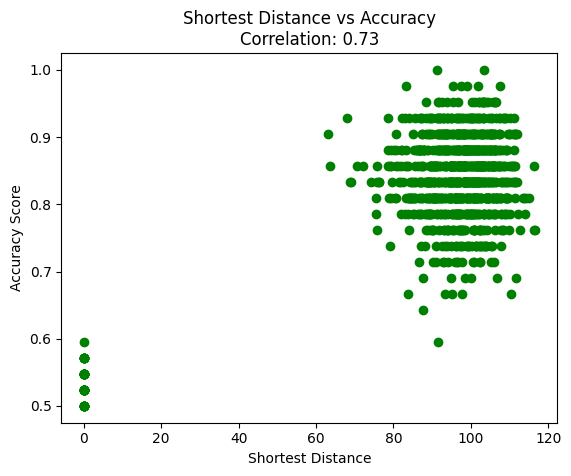

In [75]:
corr_accuracy = pearsonr(shortest_distances, accuracy_scores)[0]
plt.scatter(shortest_distances, accuracy_scores, color='green')
plt.title(f"Shortest Distance vs Accuracy\nCorrelation: {corr_accuracy:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("Accuracy Score")

Text(0, 0.5, 'AUC Score')

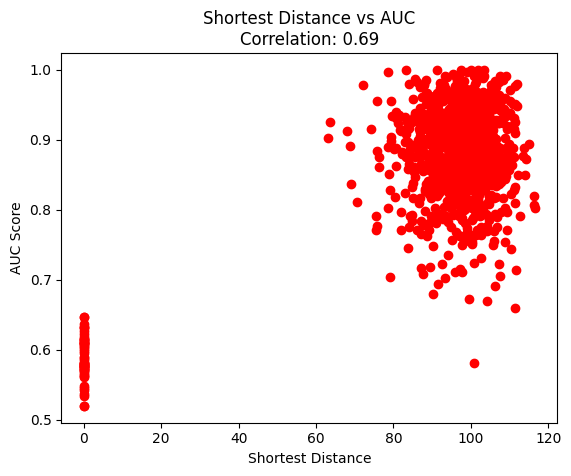

In [76]:
corr_auc = pearsonr(shortest_distances, auc_scores)[0]
plt.scatter(shortest_distances, auc_scores, color='red')
plt.title(f"Shortest Distance vs AUC\nCorrelation: {corr_auc:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("AUC Score")

Text(0, 0.5, 'F1 Score')

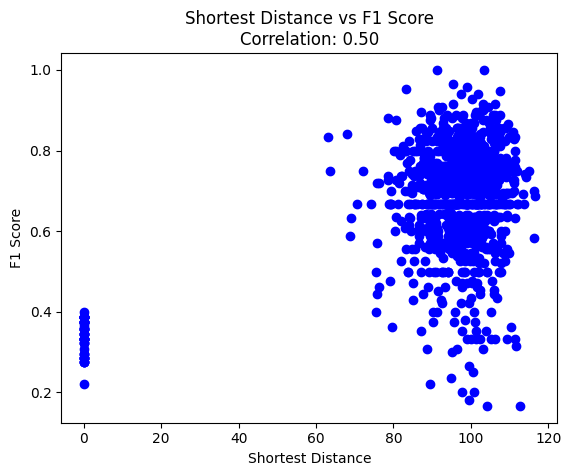

In [77]:
corr_f1 = pearsonr(shortest_distances, f1_scores)[0]
plt.scatter(shortest_distances, f1_scores, color='blue')
plt.title(f"Shortest Distance vs F1 Score\nCorrelation: {corr_f1:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("F1 Score")

# regression task

In [51]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_scores = []
mae_scores = []
r2_scores = []

for pop in tqdm(smiles_pops):
    X = []
    y = []
    for i in pop:
        mol = Chem.MolFromSmiles(cas_tox.iloc[i, 2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(cas_tox.iloc[i, 1])
    
    y_pred = model.predict(X)
    
    mse_scores.append(mean_squared_error(y, y_pred))
    mae_scores.append(mean_absolute_error(y, y_pred))
    r2_scores.append(r2_score(y, y_pred))

100%|██████████| 1071/1071 [04:26<00:00,  4.02it/s]


Text(0, 0.5, 'MSE Score')

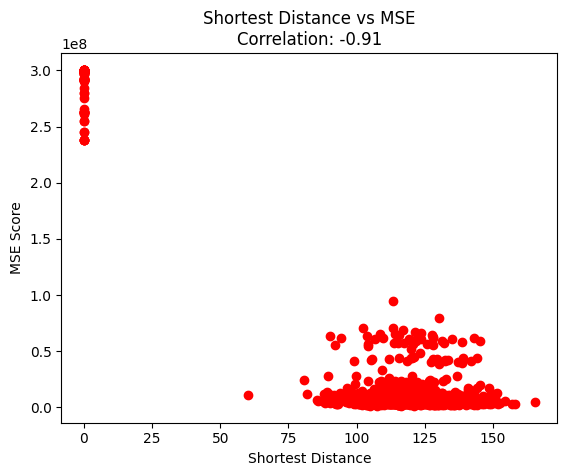

In [55]:
corr_auc = pearsonr(shortest_distances, mse_scores)[0]
plt.scatter(shortest_distances, mse_scores, color='red')
plt.title(f"Shortest Distance vs MSE\nCorrelation: {corr_auc:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("MSE Score")

Text(0, 0.5, 'MAE Score')

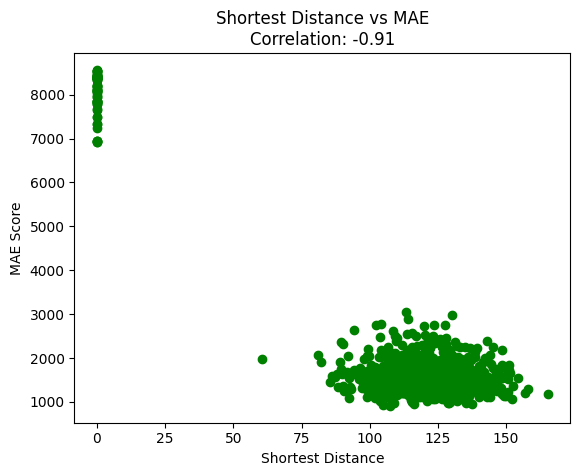

In [57]:
corr_mae = pearsonr(shortest_distances, mae_scores)[0]
plt.scatter(shortest_distances, mae_scores, color='green')
plt.title(f"Shortest Distance vs MAE\nCorrelation: {corr_mae:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("MAE Score")

Text(0, 0.5, 'R2 Score')

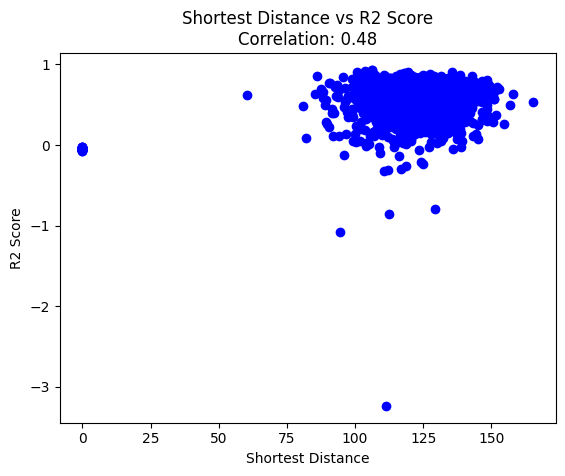

In [58]:
corr_r2 = pearsonr(shortest_distances, r2_scores)[0]
plt.scatter(shortest_distances, r2_scores, color='blue')
plt.title(f"Shortest Distance vs R2 Score\nCorrelation: {corr_r2:.2f}")
plt.xlabel("Shortest Distance")
plt.ylabel("R2 Score")

# run all test

In [2]:
def prep_tp_data(df):
    X, y = [], []
    for i in range(len(df)):
        mol = Chem.MolFromSmiles(df.iloc[i,2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(df.iloc[i,1])
    return X, y

In [3]:
def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

100%|██████████| 9/9 [1:41:13<00:00, 674.87s/it] 


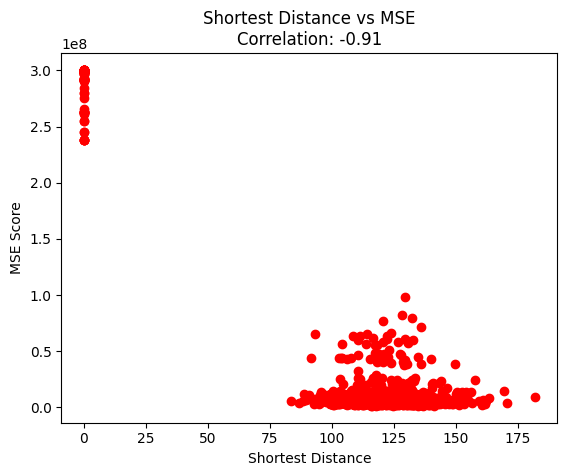

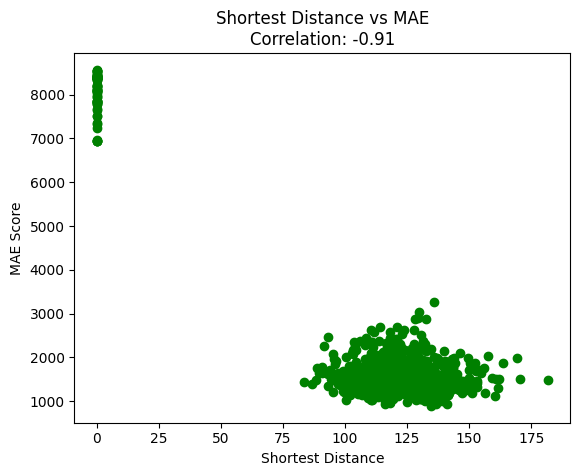

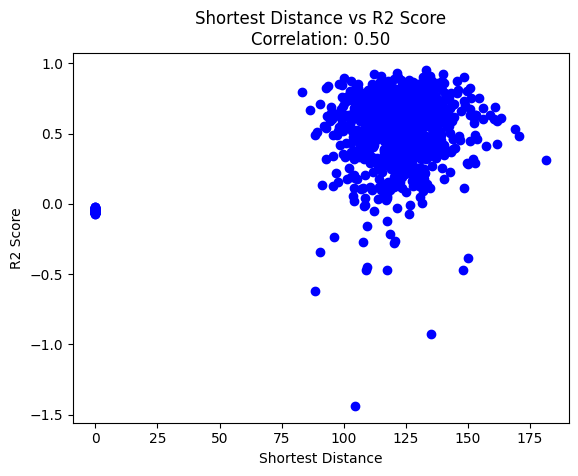

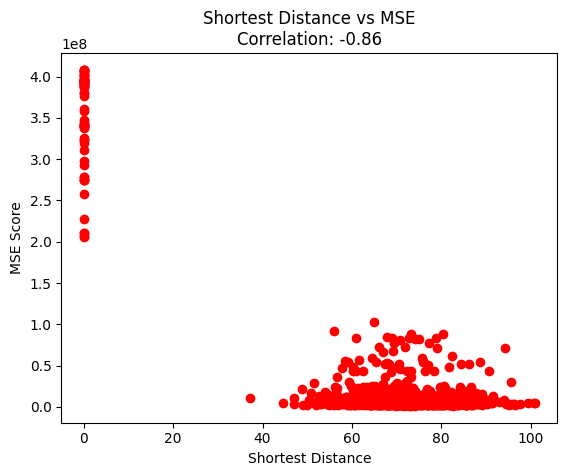

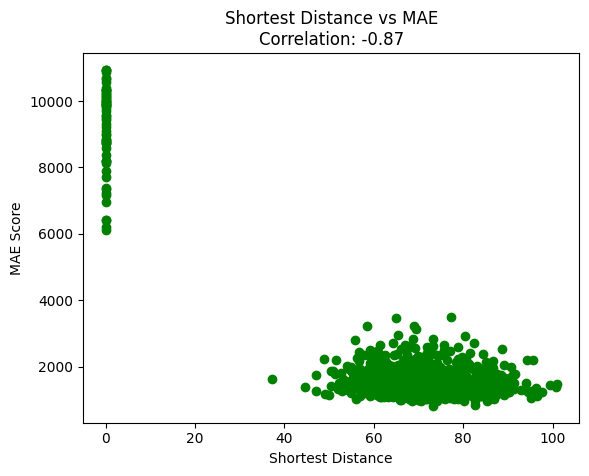

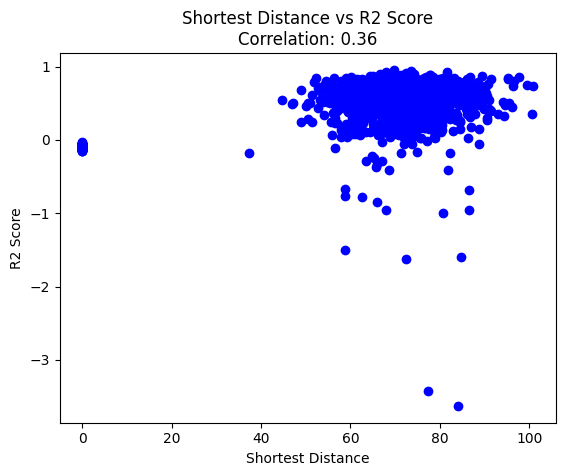

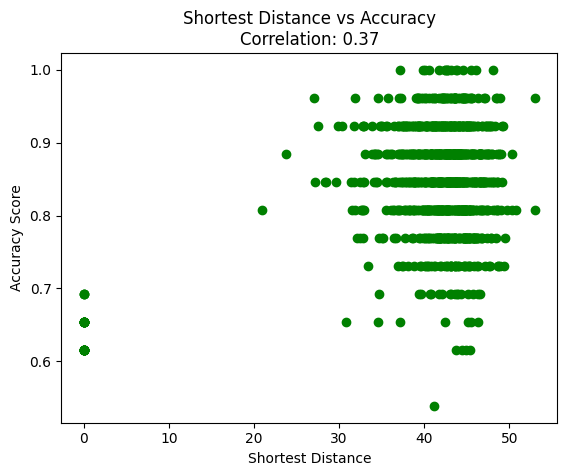

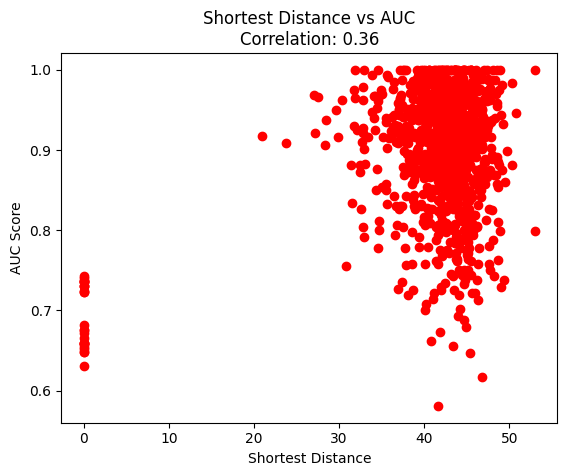

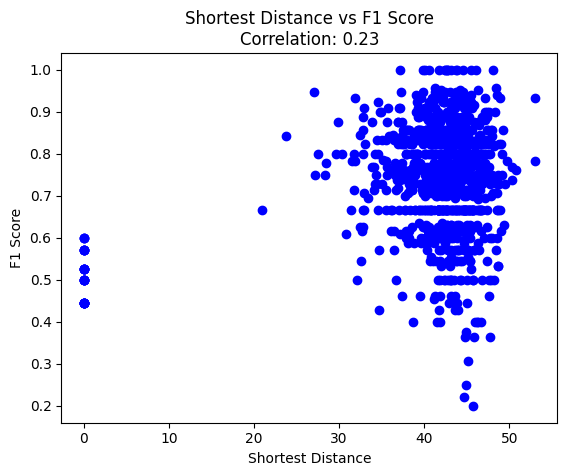

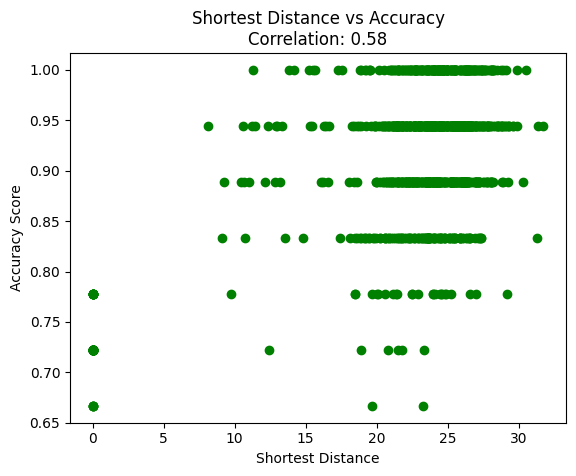

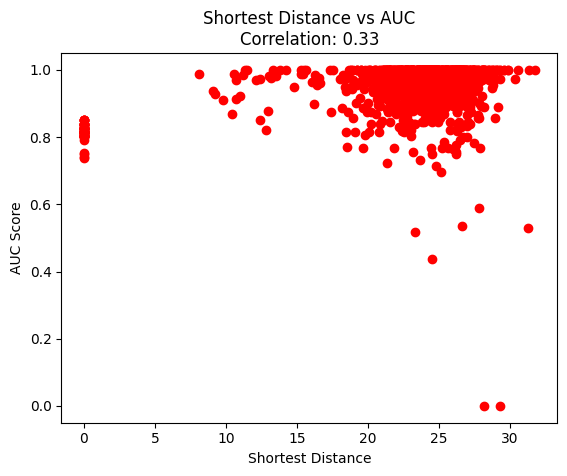

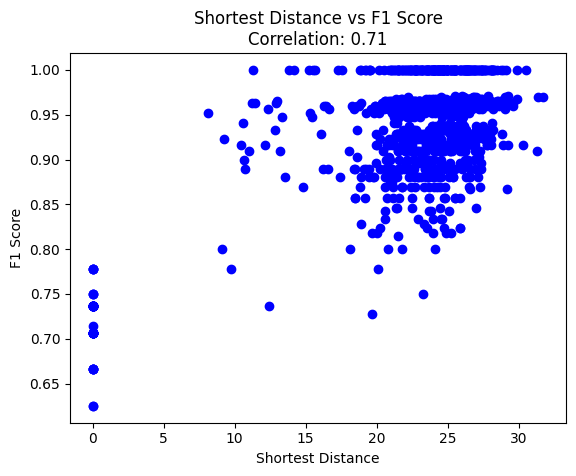

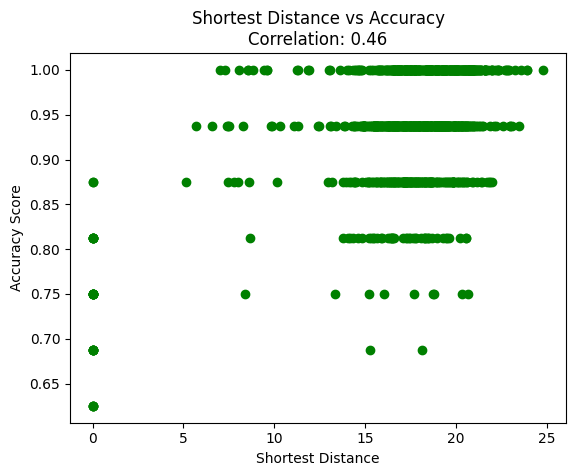

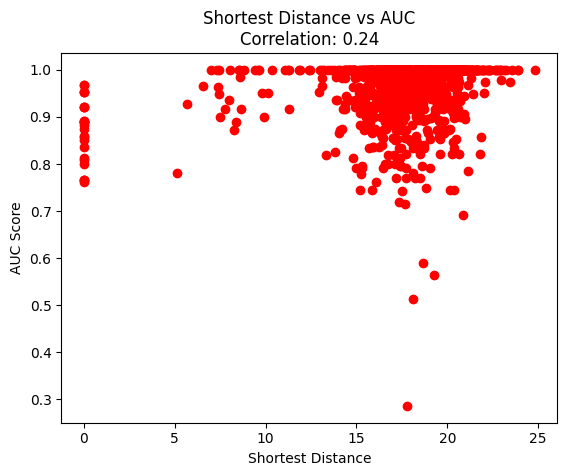

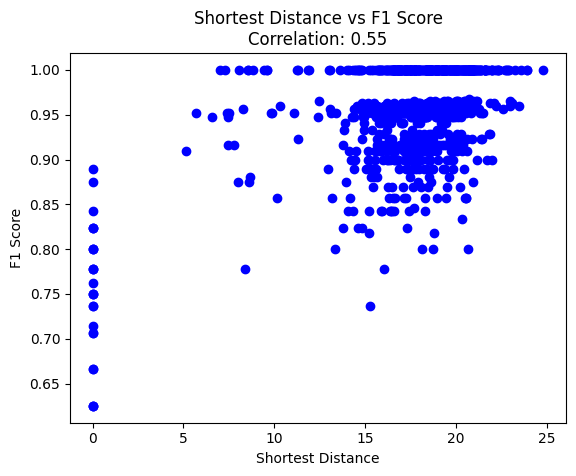

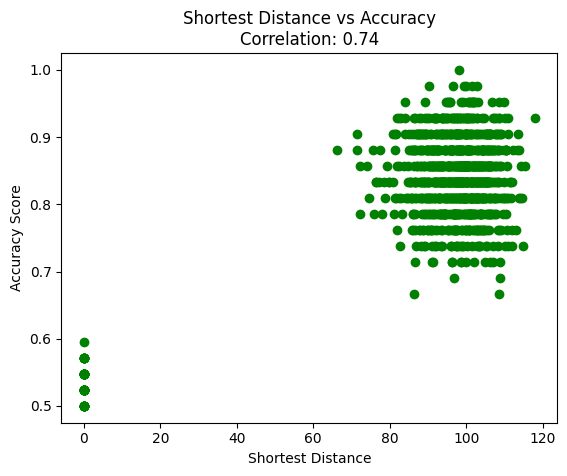

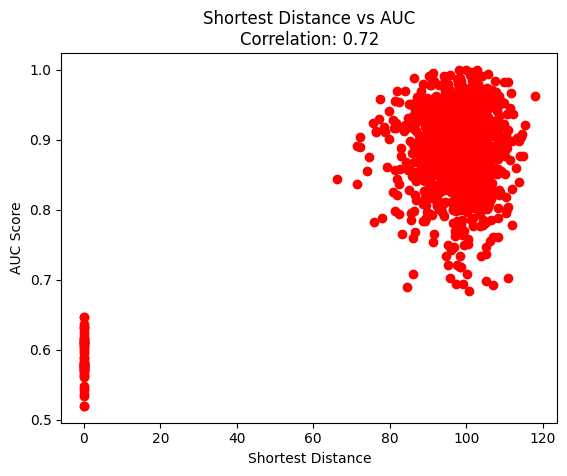

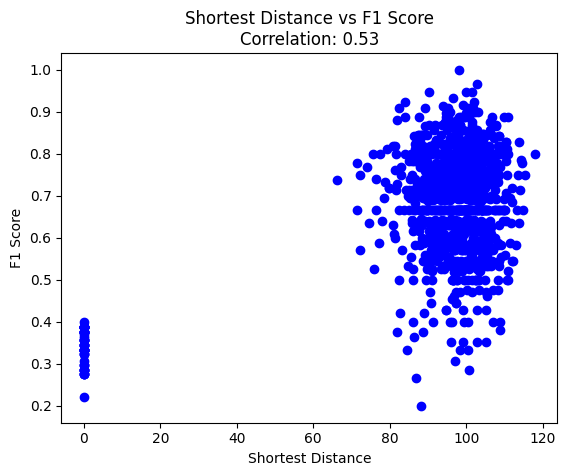

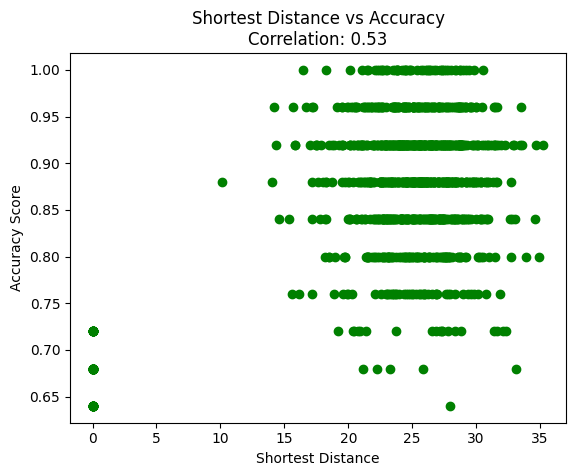

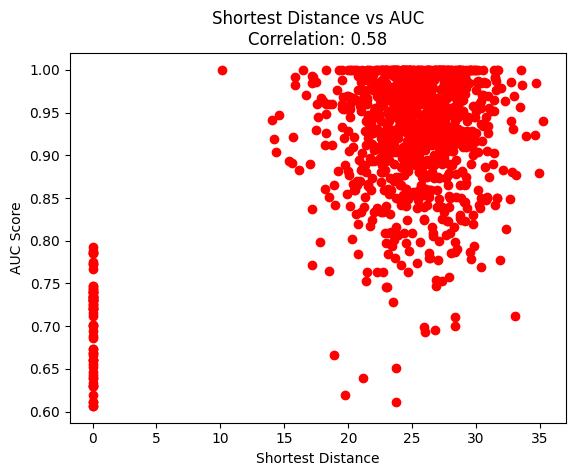

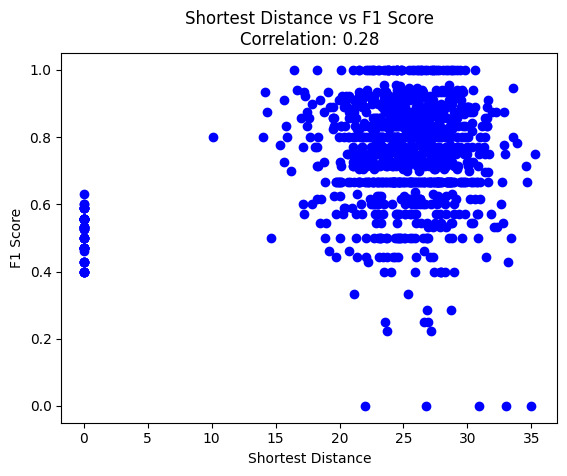

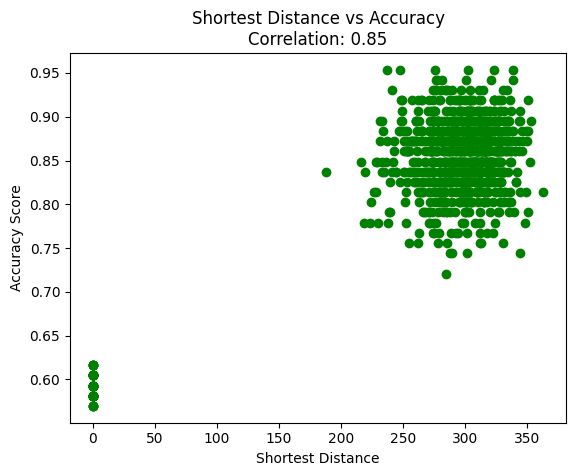

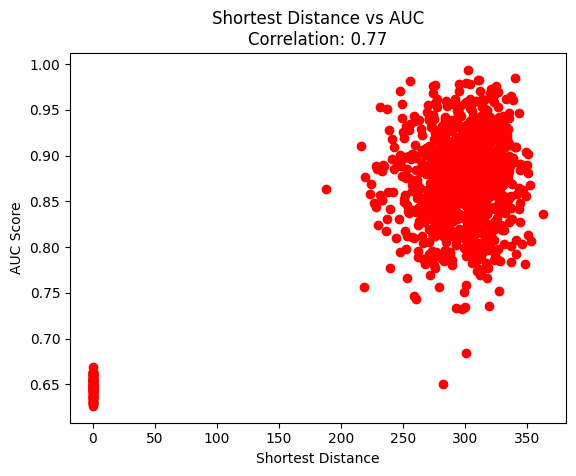

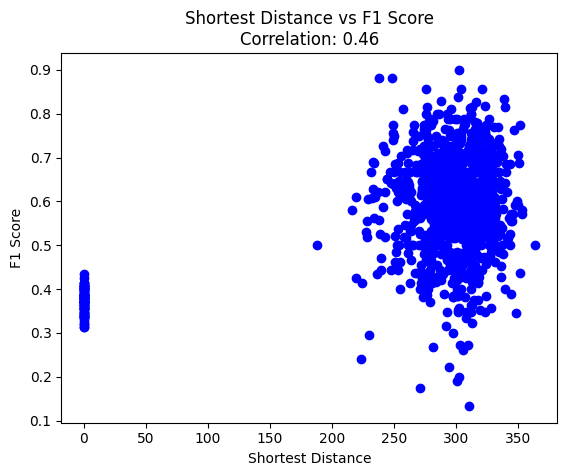

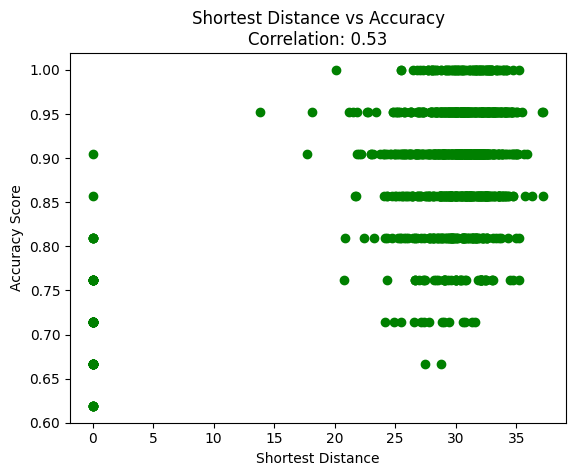

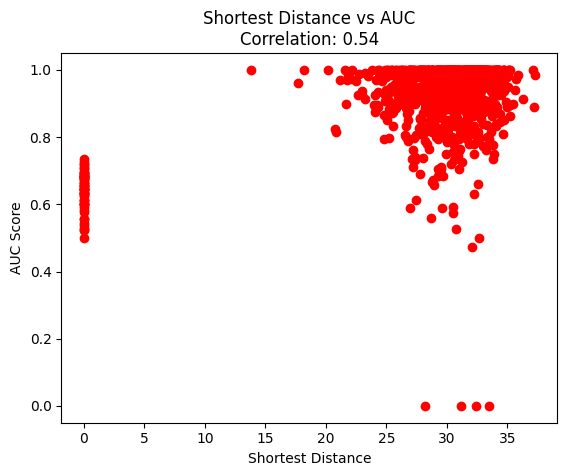

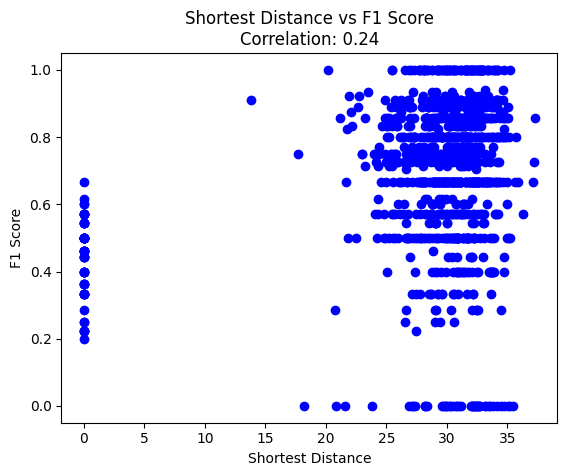

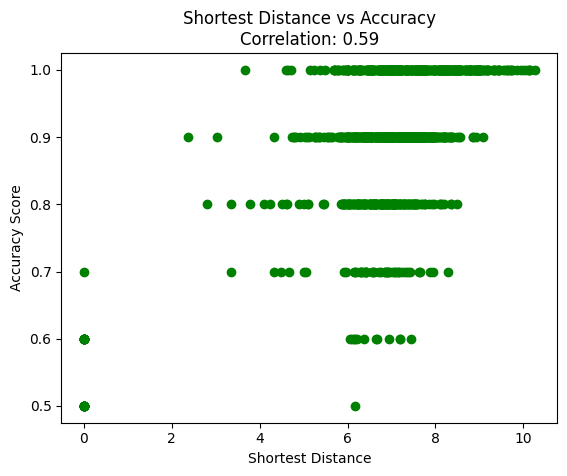

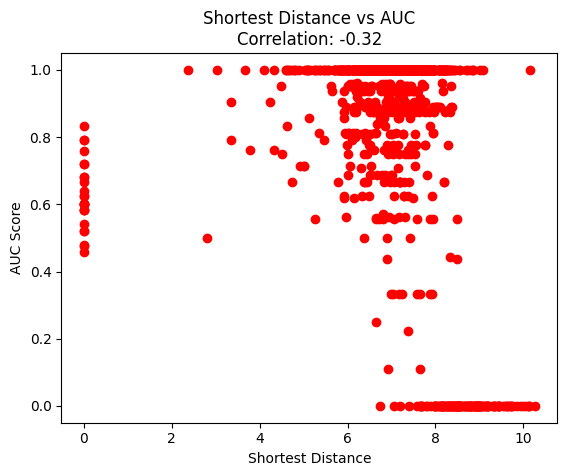

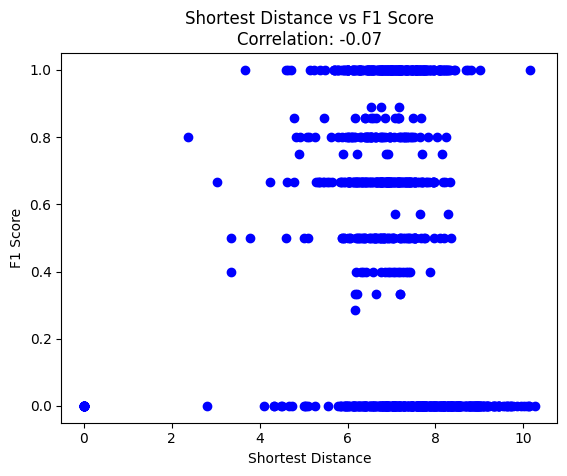

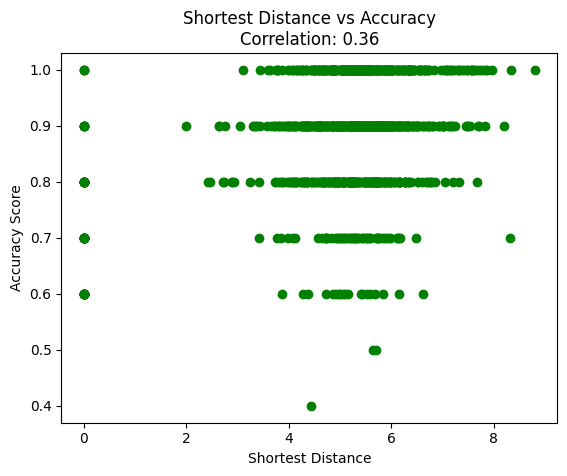

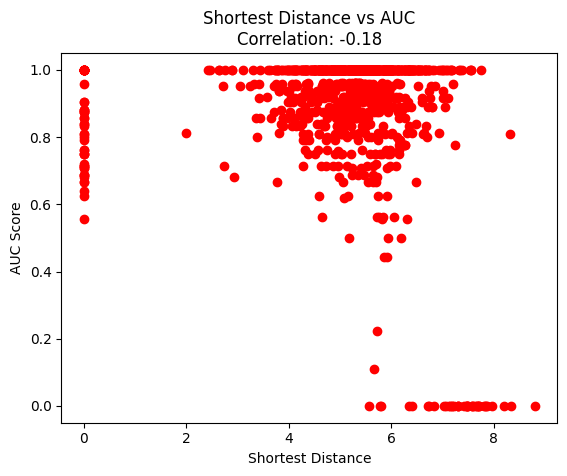

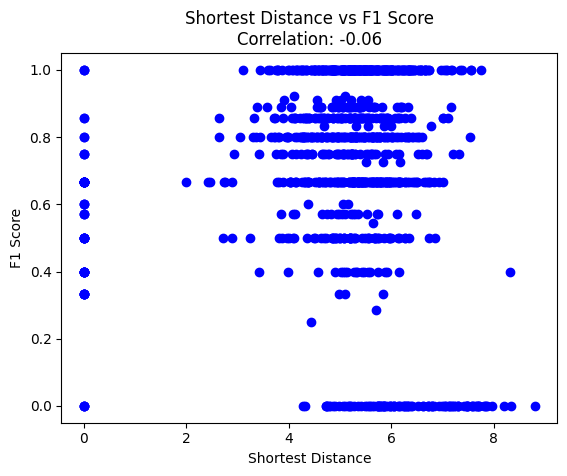

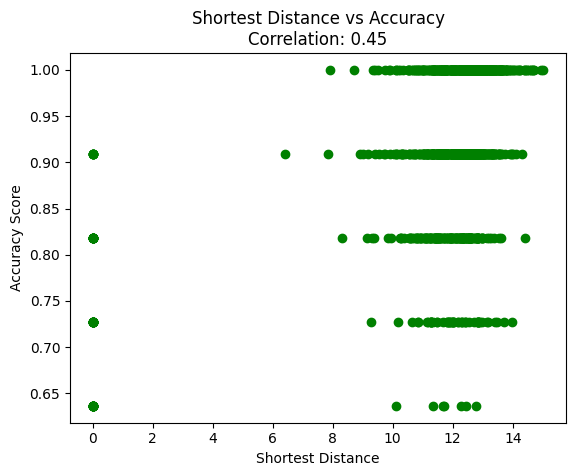

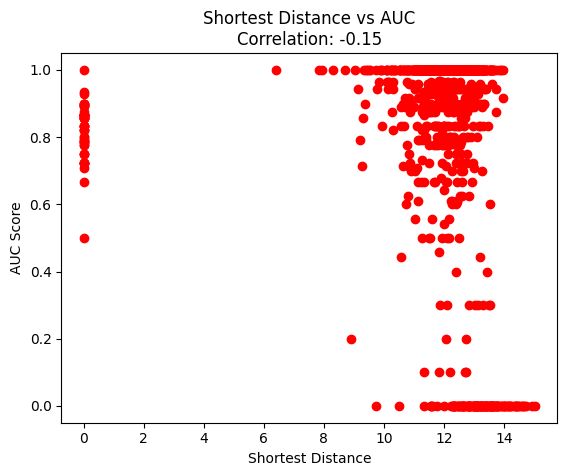

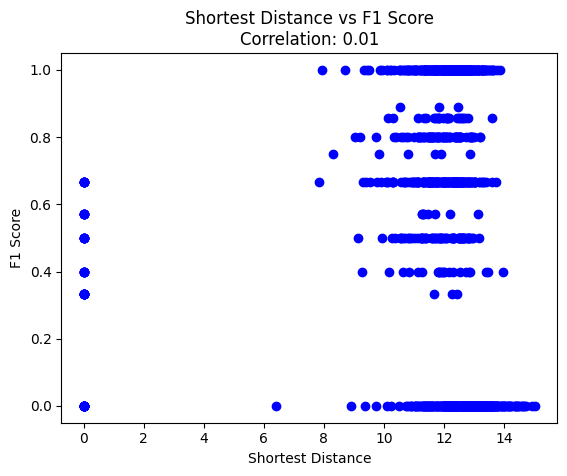

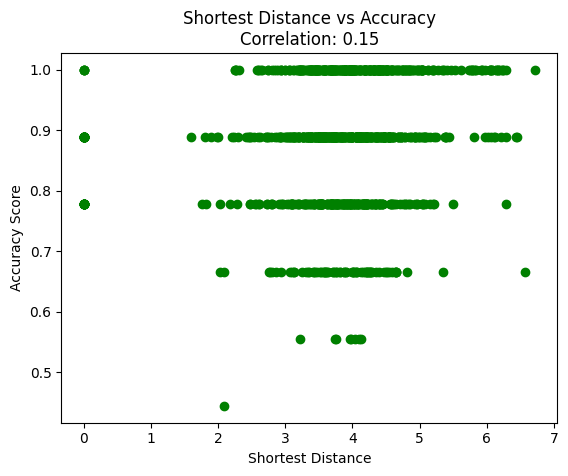

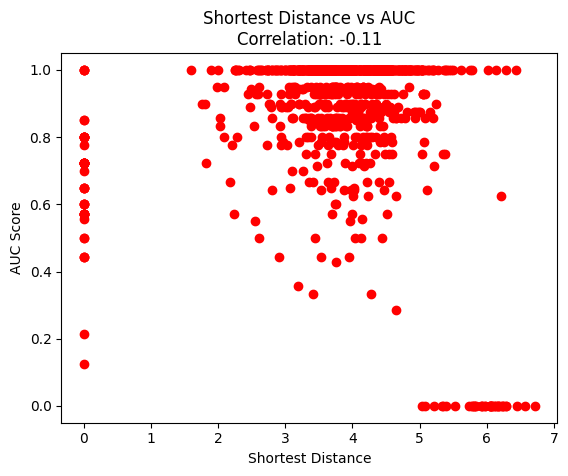

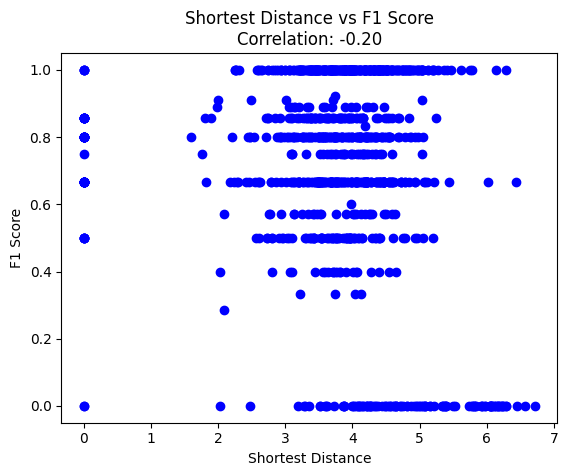

In [4]:
for test_num in tqdm(["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]):
    for lig in ["ago", "anta"]:
        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        seed = 42
        date = 241219
        num = 1

        trys = str(date) + "_" + str(num)

        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num

        for_toxpred_dir = f"../../data/result/{test_name}/GA_{trys}/toxpred_{seed}"
        result_dir = f"../../data/result/{test_name}/GA_{trys}"

        pareto = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/pareto_front.tsv", sep="\t", header=None)

        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 
        val_lookup = pickle_load(f"../../data/processed/{test_name}/validation_lookup.pickle")

        df_train = pd.read_csv(f"{for_toxpred_dir}/train.tsv", header=None, sep="\t")
        df_eval = pd.read_csv(f"{for_toxpred_dir}/eval.tsv", header=None, sep="\t")
        df_test = pd.read_csv(f"{for_toxpred_dir}/test.tsv", header=None, sep="\t")
        df_ga = pd.read_csv(f"{for_toxpred_dir}/ga.tsv", header=None, sep="\t")

        X_train, y_train = prep_tp_data(df_train)
        X_eval, y_eval = prep_tp_data(df_eval)
        X_test, y_test = prep_tp_data(df_test)
        X_ga, y_ga = prep_tp_data(df_ga)

        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        pops = []
        smiles_pops = []
        count = 0
        IND_INIT_SIZE = len(val)

        while count < 1000:
            a = [random.randint(0, len(cas_tox)-1) for i in range(IND_INIT_SIZE)] 
            a = set(a)
            while len(a) != IND_INIT_SIZE:
                a.add(random.randint(0, len(cas_tox)-1))
            score_moo = multi_objective_optimization(a)
            smiles_pops.append(list(a))
            pops.append([score_moo[0], score_moo[1], score_moo[2]])
            count += 1

        pareto_pops = []
        for i in range(len(pareto)):
            pop = [pareto.iloc[i,n] for n in range(len(pareto.iloc[i]))]
            score_moo = multi_objective_optimization(pop)
            pareto_pops.append([score_moo[0], score_moo[1], score_moo[2]])
            smiles_pops.append(list(pop))

        pareto_pops = np.array(pareto_pops)
        shortest_distances = []
        for pop in pops:
            distances = np.linalg.norm(pareto_pops - pop, axis=1)
            shortest_distance = np.min(distances)
            shortest_distances.append(shortest_distance)
    
        for pop in pareto_pops:
            distances = np.linalg.norm(pareto_pops - pop, axis=1)
            shortest_distance = np.min(distances)
            shortest_distances.append(shortest_distance)
        
        if tox_scoring == "continuous":
            model = xgb.XGBRegressor()
            model.fit(X_train, y_train)

            mse_scores = []
            mae_scores = []
            r2_scores = []

            for pop in smiles_pops:
                X = []
                y = []
                for i in pop:
                    mol = Chem.MolFromSmiles(cas_tox.iloc[i, 2])
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                    X.append(fp)
                    y.append(cas_tox.iloc[i, 1])
                
                y_pred = model.predict(X)
                
                mse_scores.append(mean_squared_error(y, y_pred))
                mae_scores.append(mean_absolute_error(y, y_pred))
                r2_scores.append(r2_score(y, y_pred))
                
            plt.figure()
            corr_auc = pearsonr(shortest_distances, mse_scores)[0]
            plt.scatter(shortest_distances, mse_scores, color='red')
            plt.title(f"Shortest Distance vs MSE\nCorrelation: {corr_auc:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("MSE Score")
            plt.savefig(f"{result_dir}/shotest_vs_mse.png", dpi=300, bbox_inches='tight')

            plt.figure()
            corr_mae = pearsonr(shortest_distances, mae_scores)[0]
            plt.scatter(shortest_distances, mae_scores, color='green')
            plt.title(f"Shortest Distance vs MAE\nCorrelation: {corr_mae:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("MAE Score")
            plt.savefig(f"{result_dir}/shotest_vs_mae.png", dpi=300, bbox_inches='tight')

            plt.figure()
            corr_r2 = pearsonr(shortest_distances, r2_scores)[0]
            plt.scatter(shortest_distances, r2_scores, color='blue')
            plt.title(f"Shortest Distance vs R2 Score\nCorrelation: {corr_r2:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("R2 Score")
            plt.savefig(f"{result_dir}/shotest_vs_r2.png", dpi=300, bbox_inches='tight')

        elif tox_scoring == "descrete":
            model = xgb.XGBClassifier()
            model.fit(X_train, y_train)

            accuracy_scores = []
            precision_scores = []
            recall_scores = []
            f1_scores = []
            auc_scores = []

            for pop in smiles_pops:
                X = []
                y = []
                for i in pop:
                    mol = Chem.MolFromSmiles(cas_tox.iloc[i,2])
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                    X.append(fp)
                    y.append(cas_tox.iloc[i,1])
                y_pred = model.predict(X)
                y_proba = model.predict_proba(X)
                y_t_proba = [n[1] for n in y_proba]

                accuracy_scores.append(accuracy_score(y, y_pred))
                precision_scores.append(precision_score(y, y_pred))
                recall_scores.append(recall_score(y, y_pred))
                f1_scores.append(f1_score(y, y_pred))
                try:
                    auc_scores.append(roc_auc_score(y, y_t_proba))
                except:
                    auc_scores.append(0)

            plt.figure()
            corr_accuracy = pearsonr(shortest_distances, accuracy_scores)[0]
            plt.scatter(shortest_distances, accuracy_scores, color='green')
            plt.title(f"Shortest Distance vs Accuracy\nCorrelation: {corr_accuracy:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("Accuracy Score")
            plt.savefig(f"{result_dir}/shotest_vs_accuracy.png", dpi=300, bbox_inches='tight')

            plt.figure()
            corr_auc = pearsonr(shortest_distances, auc_scores)[0]
            plt.scatter(shortest_distances, auc_scores, color='red')
            plt.title(f"Shortest Distance vs AUC\nCorrelation: {corr_auc:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("AUC Score")
            plt.savefig(f"{result_dir}/shotest_vs_auc.png", dpi=300, bbox_inches='tight')

            plt.figure()
            corr_f1 = pearsonr(shortest_distances, f1_scores)[0]
            plt.scatter(shortest_distances, f1_scores, color='blue')
            plt.title(f"Shortest Distance vs F1 Score\nCorrelation: {corr_f1:.2f}")
            plt.xlabel("Shortest Distance")
            plt.ylabel("F1 Score")
            plt.savefig(f"{result_dir}/shotest_vs_f1.png", dpi=300, bbox_inches='tight')